In [29]:
import numpy as np
import glob
import json
import os
from PIL import Image
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
import cv2

from imgaug import augmenters as iaa
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

from augmentation import *
from model import default_categorical
from utils import linear_bin, tub_to_array, rebalance

In [ ]:
def tub_file_names(tub_path):

    pics_list = glob.glob(tub_path + '/*.jpg')
    records_list = glob.glob(tub_path + "/record_*.json")

    pics_list.sort(key=lambda x: int(os.path.basename(x).split('_')[0]))
    records_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    
    pics_names = [os.path.basename(pic) for pic in pics_list]
            
    return pics_names

In [ ]:
# AVAILABLE TUBS
tub_20181113_42_afternoon = '/home/data/tortue-rapide/tubs/raw/tub_20181113_42_afternoon'
tub_20181113_42_evening = '/home/data/tortue-rapide/tubs/raw/tub_20181113_42_evening'
tub_20181124_morning_lesquare_horaire = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_horaire'
tub_20181124_morning_lesquare_antihoraire = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_antihoraire'
tub_20181121_ysance_evening = '/home/data/tortue-rapide/tubs/raw/tub_20181121_ysance_evening'
tub_20181122_ysance_noon = '/home/data/tortue-rapide/tubs/raw/tub_20181122_ysance_noon'
tub_20181121_ysance_evening_500 = '/home/data/tortue-rapide/tubs/raw/tub_20181121_ysance_evening_500_correction'

# EXAMPLES
img_example = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/291_cam-image_array_.jpg'
json_exple = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/record_291.json'

save_model_path = '/home/projects/tortue-rapide/franklin_gym/test_models'

# convert tubs to numpy arrays
x_42_afternoon, y_42_afternoon = tub_to_array(tub_20181113_42_afternoon, n_class=3)
# x_42_evening, y_42_evening = tub_to_array(tub_20181113_42_evening, n_class=3)
#x_morning_lesquare_horaire, y_morning_lesquare_horaire = tub_to_array(tub_20181124_morning_lesquare_horaire, n_class=3)
#x_morning_lesquare_antihoraire, y_morning_lesquare_antihoraire = tub_to_array(tub_20181124_morning_lesquare_antihoraire, n_class=3)
#X_ysance_evening, Y_ysance_evening = tub_to_array(tub_20181121_ysance_evening, n_class=3)
#X_ysance_noon, Y_ysance_noon = tub_to_array(tub_20181122_ysance_noon, n_class=3)
#X_ysance_evening_500, Y_ysance_evening_500 = tub_to_array(tub_20181121_ysance_evening_500, n_class=3)

# rebalance classes
# x_42_afternoon, y_42_afternoon = rebalance(x_42_afternoon, y_42_afternoon)
# x_42_evening, y_42_evening = rebalance(x_42_evening, y_42_evening)
# x_morning_lesquare_horaire, y_morning_lesquare_horaire = rebalance(x_morning_lesquare_horaire, y_morning_lesquare_horaire)

# train / validation split
# X_train = np.concatenate((x_42_afternoon, x_morning_lesquare_antihoraire, x_morning_lesquare_horaire))
# Y_train = np.concatenate((y_42_afternoon, y_morning_lesquare_antihoraire, y_morning_lesquare_horaire)) 
# X_val, Y_val = X_ysance_noon[:20000], Y_ysance_noon[:20000]

In [ ]:
new_tub_path = '/home/data/tortue-rapide/tubs/npy_format/tub_20181113_42_afternoon/'
!mkdir {new_tub_path}

for n in range(len(x_42_afternoon)):
    np.save(file = new_tub_path + 'X_' + str(n), arr=x_42_afternoon[n])
    np.save(file = new_tub_path + 'y_' + str(n), arr=y_42_afternoon[n])

In [ ]:
# files name
morning_lesquare_horaire_filenames = tub_file_names(tub_20181124_morning_lesquare_horaire)
morning_lesquare_antihoraire_filenames = tub_file_names(tub_20181124_morning_lesquare_antihoraire)
#ysance_evening_filenames = tub_file_names(tub_20181121_ysance_evening)
#ysance_evening_500_filenames = tub_file_names(tub_20181121_ysance_evening_500)

In [ ]:
x_morning_lesquare_horaire.shape

In [ ]:
plt.figure(figsize=(13,12))
show_rank=110
for n in range(9):
    plt.subplot(3, 3,n+1)
    plt.imshow(X_ysance_evening_500[n+show_rank][30:])

In [ ]:
plt.figure(figsize=(13,12))
for n in range(9):
  plt.subplot(3,3,n+1)
  select = np.random.randint(len(x_morning_lesquare_horaire))
  plt.imshow(x_morning_lesquare_horaire[select][30:])
  plt.title(str(y_morning_lesquare_horaire[select]) + '\n' + 
            str(morning_lesquare_horaire_filenames[select]))
  plt.axis('off')

In [ ]:
start = 4150
gap = 5

plt.figure(figsize=(13,80))
for n in range(60):
  plt.subplot(20,3,n+1)
  plt.imshow(x_morning_lesquare_antihoraire[start+n*gap][30:])
  plt.title(str(y_morning_lesquare_antihoraire[start+n*gap]) + '\n' + 
            str(morning_lesquare_antihoraire_filenames[start+n*gap]))
  plt.axis('off')

In [ ]:
%%bash
cat /home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_horaire/record_2764.json

In [ ]:
import matplotlib.pyplot as plt

def plot_class_histogram(Y):
    '''
    Y : categorical numpy array'''
    a = [1, 2, 3]
    fi = [sum(n * a) for n in Y]
    
    plt.hist(fi, bins='auto')

plot_class_histogram(Y_ysance_evening_500)

In [ ]:
Y_ysance_evening_500[0]

In [ ]:
# MAP DATA PREPARATION

train_tubs = ['tub_20181113_42_afternoon', 
              'tub_20181113_42_evening',
              'tub_20181124_morning_lesquare_antihoraire']
validation_tubs = ['tub_20181122_ysance_noon']

rebalance_tubs = ['tub_20181113_42_afternoon', 
                  'tub_20181113_42_evening']

# 'tweak_luminosity'
# 'add_snow'
# 'add_shadow'
# 'add_blur'
# 'add_gaussian_noise'
# 'random_shadows'
# 'generate_night_effect' 
# 'generate_brightness'
# 'generate_contrast_normalization'
augmentation_functions = ['tweak_luminosity', 'generate_contrast_normalization']

PROPORTION = 0.1

In [ ]:
print('{} samples'.format(len(X_train)))

for augment in augmentation_functions:
    if augment in transform_dict.keys():
        print(augment)
        f = transform_dict[augment]
        X_transfo, Y_transfo = transform(X_train, Y_train, transformation=f, proportion=PROPORTION)
        X_train = np.concatenate((X_train, X_transfo))
        Y_train = np.concatenate((Y_train, Y_transfo)) 
        

print('{} samples'.format(len(X_train)))

In [ ]:
len(X_train)

In [ ]:
image_ori = np.concatenate((image_ori, image_HLS))

In [ ]:
image_ori.shape

In [ ]:
bight_x_train_5eme, bright_y_train_5eme = aug.generate_brightness(X_train, Y_train)
bight_x_train_5eme, bright_y_train_5eme = aug.generate_night_effect(X_train, Y_train)
bight_x_train_5eme, bright_y_train_5eme = aug.generate_random_shadows(X_train, Y_train)

In [ ]:
# fit model

epochs=100
steps=100
verbose=1
min_delta=.0005
patience=5
use_early_stop=True


model = default_categorical()

# checkpoint to save model after each epoch
save_best = ModelCheckpoint(save_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best]

if use_early_stop:
    callbacks_list.append(early_stop)

model.summary()
    
# fit from numpy array
#hist = model.fit(x=X_train,
#                 y=Y_train,
#                 steps_per_epoch=steps,
#                 epochs=epochs,
#                 verbose=1,
#                 validation_data=(X_val, Y_val),
#                 callbacks=callbacks_list,
#                 validation_steps=200/8)

# fit from generator
data_gen = TubTo3DGenerator('/home/data/tortue-rapide/tubs/npy_format/tub_20181113_42_afternoon/', 46)

hist = model.fit_generator(data_gen, 
                           steps_per_epoch=int(5000/46)+1,
                          epochs=10)

In [30]:
from utils import TubTo3DGenerator

In [125]:
a = TubTo3DGenerator('/home/data/tortue-rapide/tubs/raw/tub_20190502_bench_phu_low_tension//', 
                   batch_size=32, frames_per_stack=3, shuffle=True, frame_jump=4)

In [94]:
a.indexes

array([   1,    2,    3, ..., 4914, 4915, 4916])

In [126]:
X, y = a.__getitem__(0)

In [121]:
X.shape

(32, 3, 120, 160, 3)

Text(0.5, 1.0, '[0. 1. 0.]')

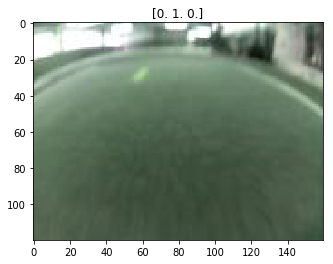

In [37]:
import matplotlib.pyplot as plt

n = 10

plt.imshow(X[n][0]/255)
plt.title(str(y[n]))

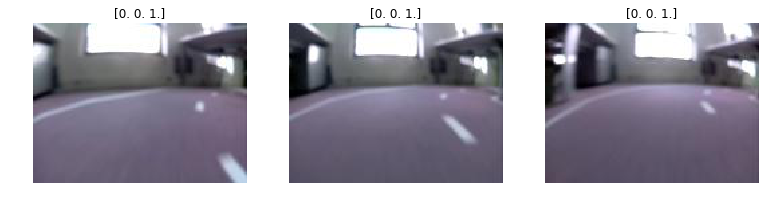

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,20))
frame = 9
for n in range(a.frames_per_stack):
  plt.subplot(5,3,n+1)
  plt.imshow(X[frame][n]/255)
  plt.title(str(y[frame]))
  plt.axis('off')

In [ ]:
from imageio import imread
from tensorflow.python.keras.utils import to_categorical

y = np.empty((64, 3), dtype=int)

y[0] = to_categorical(.5, 3)

In [ ]:
from utils import generate_verified_tub_from_indexes

generate_verified_tub_from_indexes(original_tub_path = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_horaire/', 
                      new_tub_path = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_horaire_VERIFIED/', 
                      verified_indexes = horaire)

In [ ]:
generate_verified_tub_from_indexes(original_tub_path = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_antihoraire/', 
                      new_tub_path = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_antihoraire_VERIFIED/', 
                      verified_indexes = antihoraire)

In [2]:
from albumentations.augmentations.transforms import Normalize
from utils import newtub_to_array

In [3]:
X_train, Y_train = newtub_to_array('/home/data/tortue-rapide/sets/raw/ysance_abbey_epingle_20190513/', n_class=3)
#X_train = X_train/255-.5

In [4]:
n = Normalize()

In [6]:
n.apply(X_train[0])

array([[[-0.04580877,  0.15266107, -0.06152503],
        [-0.04580877,  0.15266107, -0.06152503],
        [-0.06293352,  0.13515407, -0.07895423],
        ...,
        [-1.5699118 , -1.160364  , -1.595294  ],
        [-1.6555356 , -1.247899  , -1.68244   ],
        [-1.7069099 , -1.30042   , -1.7347276 ]],

       [[-0.02868401,  0.13515407, -0.06152503],
        [-0.04580877,  0.15266107, -0.06152503],
        [-0.06293352,  0.13515407, -0.07895423],
        ...,
        [-1.6041614 , -1.1953781 , -1.6301525 ],
        [-1.6897851 , -1.2829131 , -1.7172984 ],
        [-1.7411593 , -1.3354341 , -1.769586  ]],

       [[-0.04580877,  0.11764707, -0.07895423],
        [-0.06293352,  0.10014007, -0.09638342],
        [-0.11430778,  0.08263307, -0.1312418 ],
        ...,
        [-1.6555356 , -1.247899  , -1.68244   ],
        [-1.7240345 , -1.3179271 , -1.7521569 ],
        [-1.7925336 , -1.3879551 , -1.8044444 ]],

       ...,

       [[-0.09718303, -0.05742294, -0.21838777],
        [-0

In [8]:
X_train/255-.5

array([[[[-0.0254902 , -0.00980392, -0.10784314],
         [-0.0254902 , -0.00980392, -0.10784314],
         [-0.02941176, -0.01372549, -0.11176471],
         ...,
         [-0.3745098 , -0.30392157, -0.45294118],
         [-0.39411765, -0.32352941, -0.47254902],
         [-0.40588235, -0.33529412, -0.48431373]],

        [[-0.02156863, -0.01372549, -0.10784314],
         [-0.0254902 , -0.00980392, -0.10784314],
         [-0.02941176, -0.01372549, -0.11176471],
         ...,
         [-0.38235294, -0.31176471, -0.46078431],
         [-0.40196078, -0.33137255, -0.48039216],
         [-0.41372549, -0.34313725, -0.49215686]],

        [[-0.0254902 , -0.01764706, -0.11176471],
         [-0.02941176, -0.02156863, -0.11568627],
         [-0.04117647, -0.0254902 , -0.12352941],
         ...,
         [-0.39411765, -0.32352941, -0.47254902],
         [-0.40980392, -0.33921569, -0.48823529],
         [-0.4254902 , -0.35490196, -0.5       ]],

        ...,

        [[-0.0372549 , -0.05686275, -0